# Loading libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import os

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")

# Path

In [6]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

# Data Reading

In [7]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [8]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [9]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [10]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [13]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [14]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [15]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

In [16]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))

In [17]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|
+------+---+------+---+-------+-------------------+---+----+------+
only showing top 5 rows



# Count Features - IP Addresses

In [64]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

count_features = (data
                  .withColumn('click_time_seconds',
                              (unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21'))))
                  .groupBy('ip')
                  .agg(func.count('ip').alias('ip_nb_clicks'),
                       func.countDistinct(col('app')).alias('ip_nb_apps'),
                       func.countDistinct(col('device')).alias('ip_nb_devices'),
                       func.countDistinct(col('os')).alias('ip_nb_os'),
                       func.countDistinct(col('channel')).alias('ip_nb_channels'),
                       func.round(func.stddev(col('click_time_seconds'))).alias('ip_std_click_time'),
                       func.round(func.stddev(col('hour')), 2).alias('ip_std_hour'),
                       func.round(func.stddev(col('minute')), 2).alias('ip_std_minute'),
                       func.round(func.mean(col('hour')), 2).alias('ip_avg_hour'),
                       func.round(func.mean(col('minute')), 2).alias('ip_avg_minute'))
                  .fillna({'ip_std_click_time':0,
                           'ip_std_hour':0,
                           'ip_std_minute':0,
                           'ip_avg_hour':0,
                           'ip_avg_minute':0})
                  .cache())

count_features.show(100, truncate=False)

+------+------------+----------+-------------+--------+--------------+-----------------+-----------+-------------+-----------+-------------+
|ip    |ip_nb_clicks|ip_nb_apps|ip_nb_devices|ip_nb_os|ip_nb_channels|ip_std_click_time|ip_std_hour|ip_std_minute|ip_avg_hour|ip_avg_minute|
+------+------------+----------+-------------+--------+--------------+-----------------+-----------+-------------+-----------+-------------+
|166908|1645        |38        |5            |39      |94            |41607.0          |6.3        |17.13        |9.08       |29.73        |
|103123|14331       |73        |16           |75      |120           |99868.0          |5.96       |17.19        |10.99      |28.88        |
|91788 |781         |32        |2            |27      |83            |111908.0         |5.88       |18.72        |8.77       |28.99        |
|29573 |4840        |50        |10           |49      |110           |99635.0          |5.9        |16.67        |8.37       |27.19        |
|5325  |4890 

In [65]:
# Export new features
(count_features
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_counts_week_ip", compression="None"))

count_features.count()

364779

### Check the impact of new features

In [66]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(count_features, ['ip'], 'left_outer')
                .cache())

In [67]:
features = ['ip_nb_clicks', 'ip_nb_apps', 'ip_nb_devices', 'ip_nb_os', 'ip_nb_channels',
           'ip_std_click_time', 'ip_std_hour', 'ip_std_minute', 'ip_avg_hour', 'ip_avg_minute']

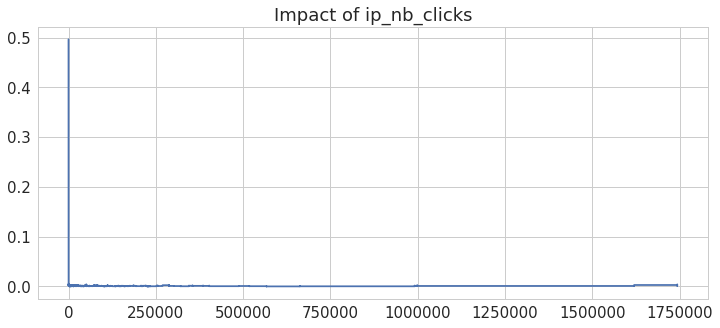

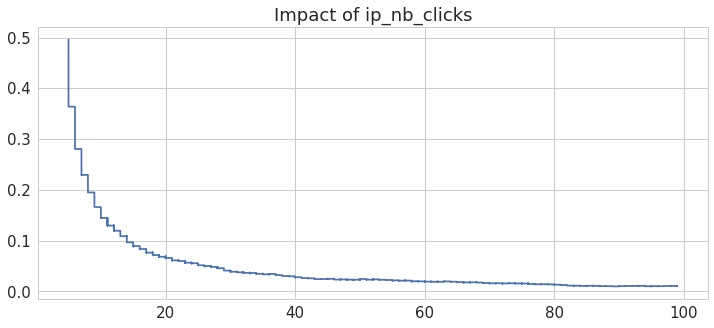

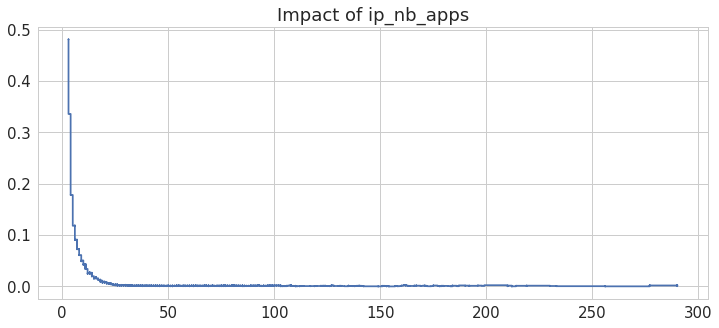

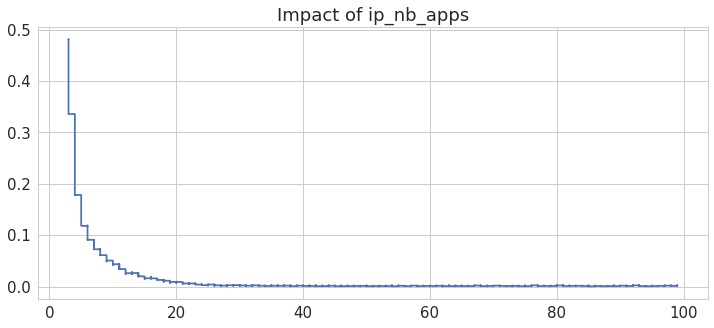

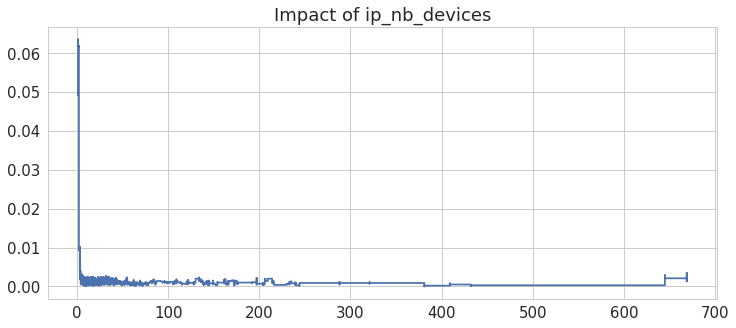

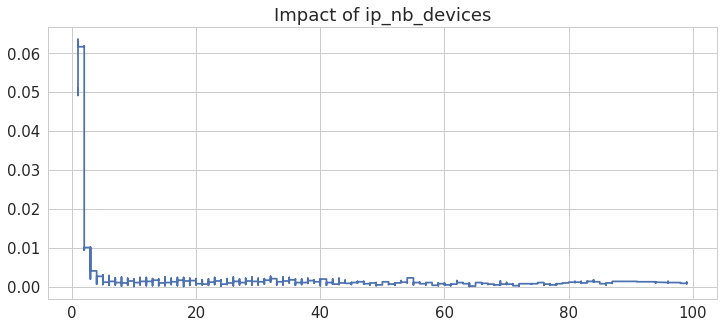

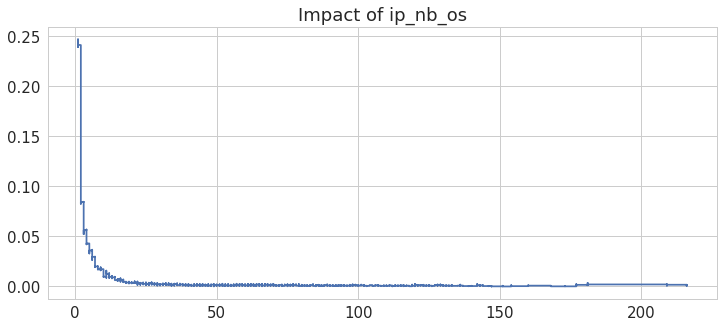

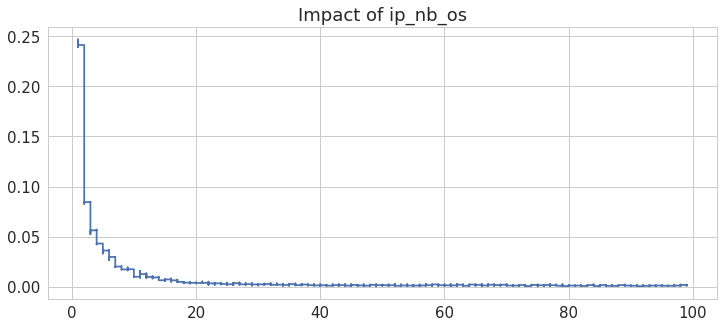

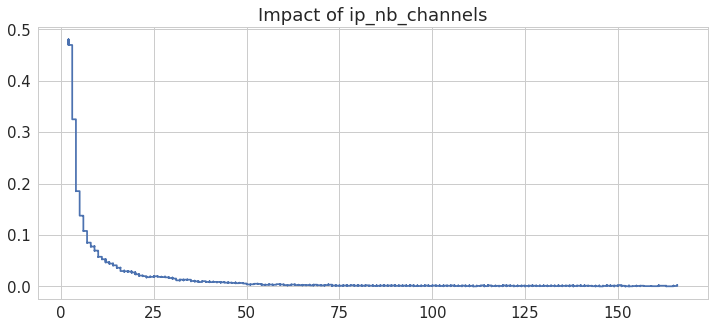

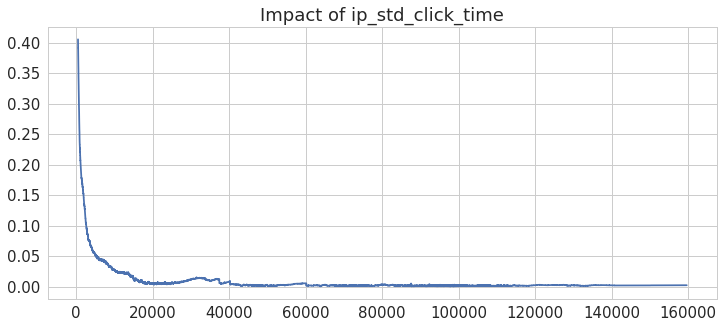

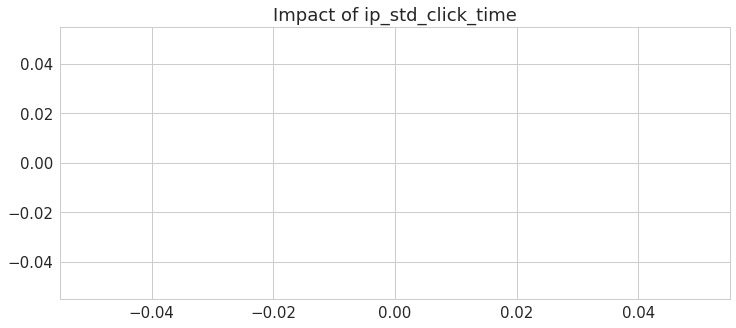

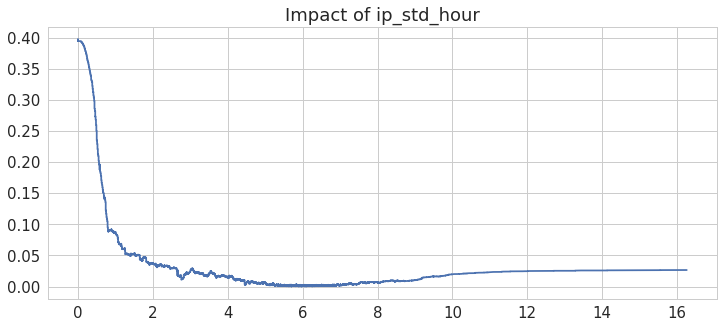

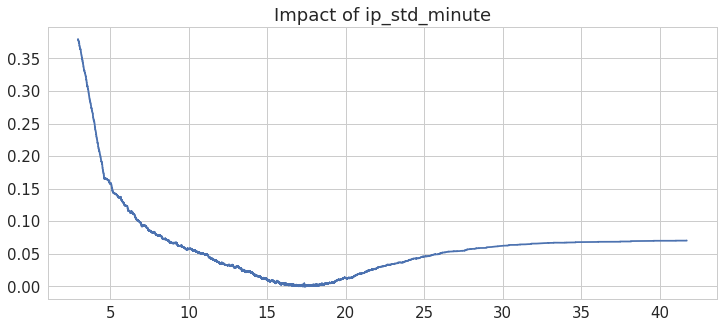

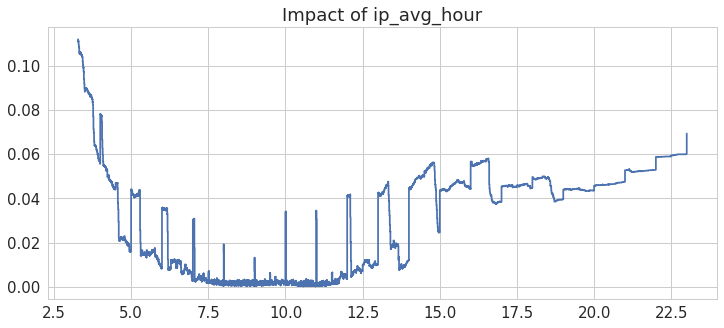

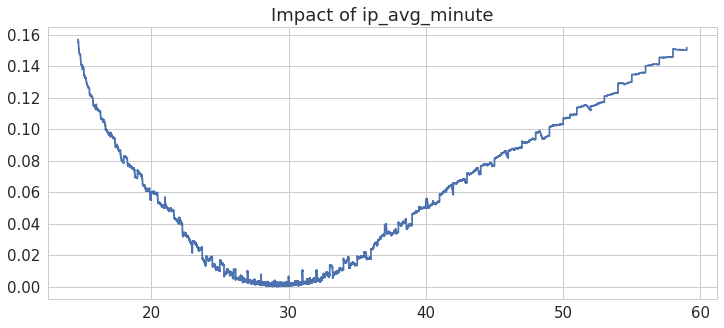

In [68]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()

# Count Features - Apps

In [69]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

count_features = (data
                  .withColumn('click_time_seconds',
                              (unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21'))))
                  .groupBy('app')
                  .agg(func.count('app').alias('app_nb_clicks'),
                       func.countDistinct(col('ip')).alias('app_nb_ips'),
                       func.countDistinct(col('device')).alias('app_nb_devices'),
                       func.countDistinct(col('os')).alias('app_nb_os'),
                       func.countDistinct(col('channel')).alias('app_nb_channels'),
                       func.round(func.stddev(col('click_time_seconds'))).alias('app_std_click_time'),
                       func.round(func.stddev(col('hour')), 2).alias('app_std_hour'),
                       func.round(func.stddev(col('minute')), 2).alias('app_std_minute'),
                       func.round(func.mean(col('hour')), 2).alias('app_avg_hour'),
                       func.round(func.mean(col('minute')), 2).alias('app_avg_minute'))
                  .fillna({'app_std_click_time':0,
                           'app_std_hour':0,
                           'app_std_minute':0,
                           'app_avg_hour':0,
                           'app_avg_minute':0})
                  .cache())

count_features.show(100, truncate=False)

+---+-------------+----------+--------------+---------+---------------+------------------+------------+--------------+------------+--------------+
|app|app_nb_clicks|app_nb_ips|app_nb_devices|app_nb_os|app_nb_channels|app_std_click_time|app_std_hour|app_std_minute|app_avg_hour|app_avg_minute|
+---+-------------+----------+--------------+---------+---------------+------------------+------------+--------------+------------+--------------+
|296|497          |392       |5             |10       |1              |71876.0           |4.79        |16.3          |8.64        |30.16         |
|675|3            |1         |2             |1        |1              |13.0              |0.0         |0.58          |16.0        |44.33         |
|467|2            |1         |2             |2        |1              |108067.0          |4.24        |19.09         |5.0         |39.5          |
|691|1            |1         |1             |1        |1              |0.0               |0.0         |0.0           |

In [70]:
# Export new features
(count_features
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_counts_week_app", compression="None"))

count_features.count()

769

### Check the impact of new features

In [71]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(count_features, ['app'], 'left_outer')
                .cache())

In [72]:
features = ['app_nb_clicks', 'app_nb_ips', 'app_nb_devices', 'app_nb_os', 'app_nb_channels',
           'app_std_click_time', 'app_std_hour', 'app_std_minute', 'app_avg_hour', 'app_avg_minute']

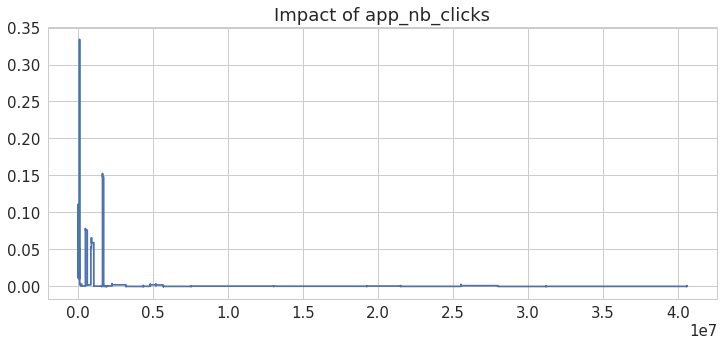

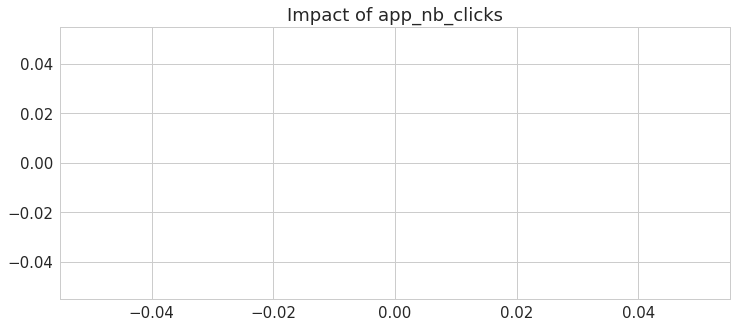

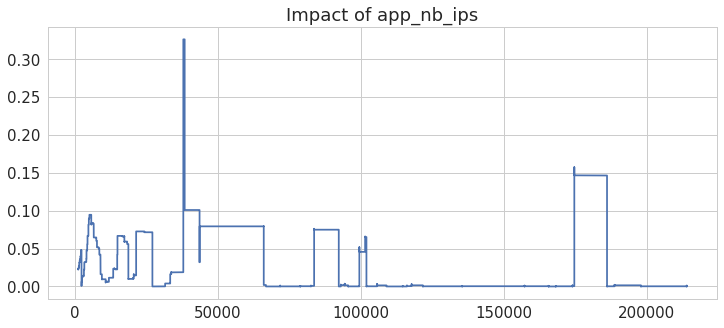

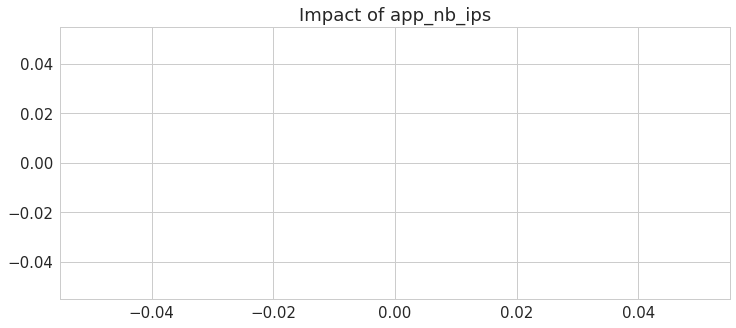

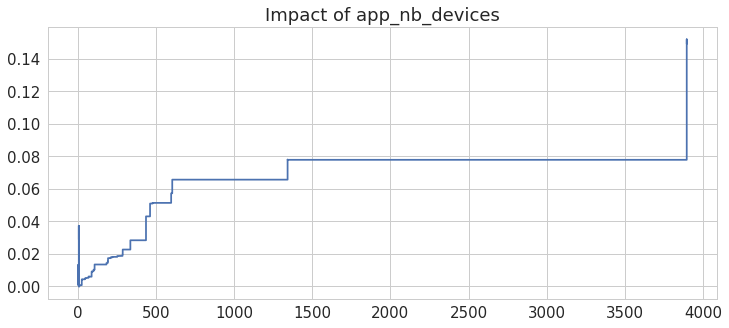

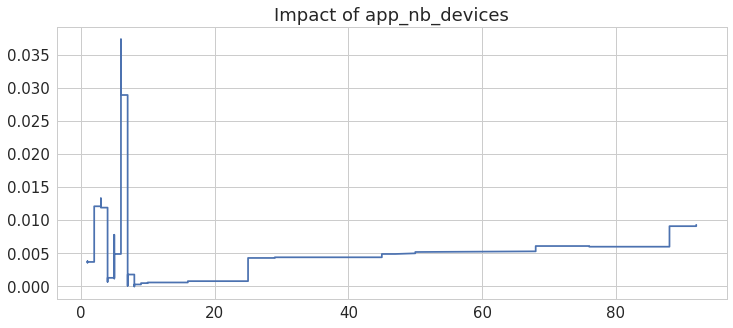

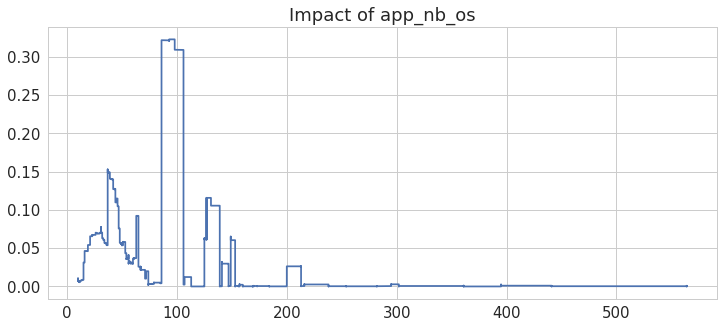

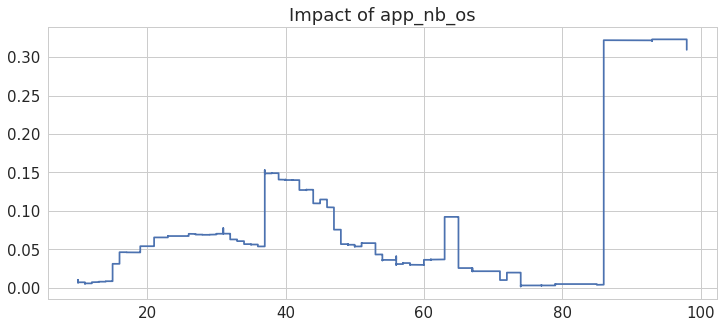

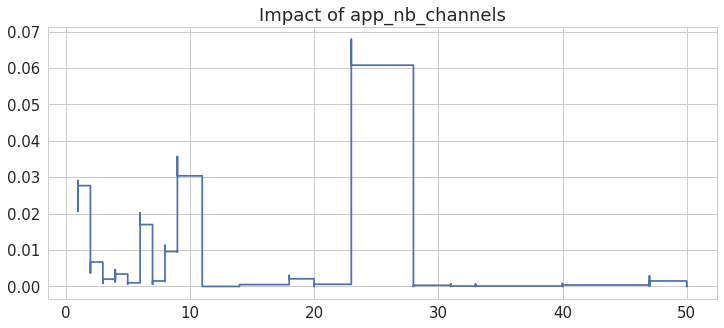

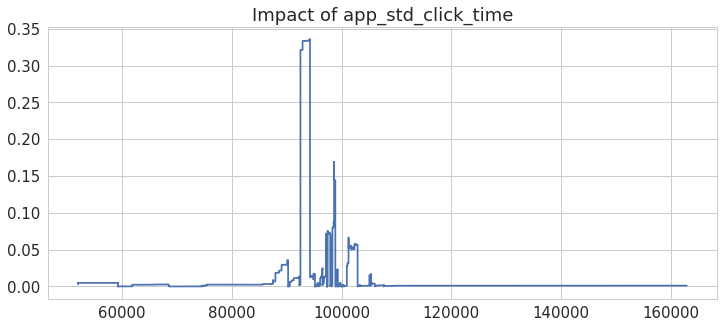

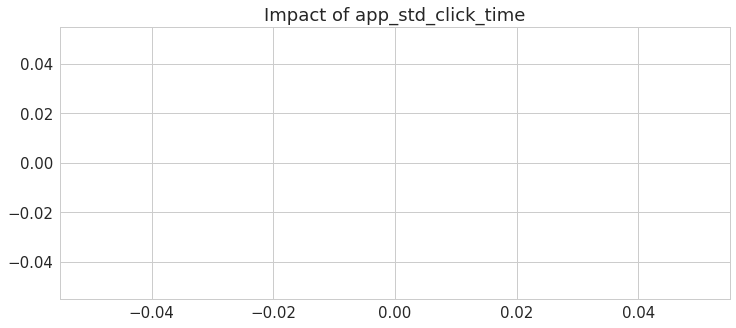

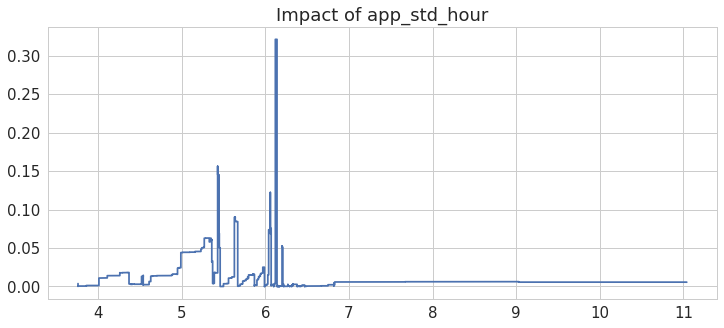

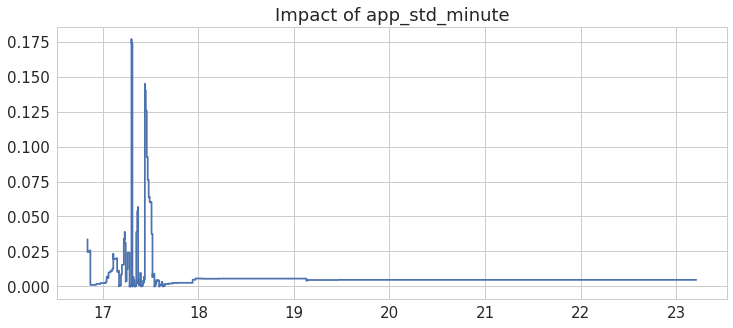

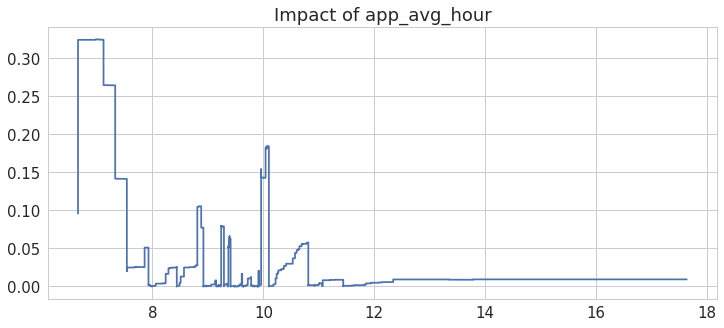

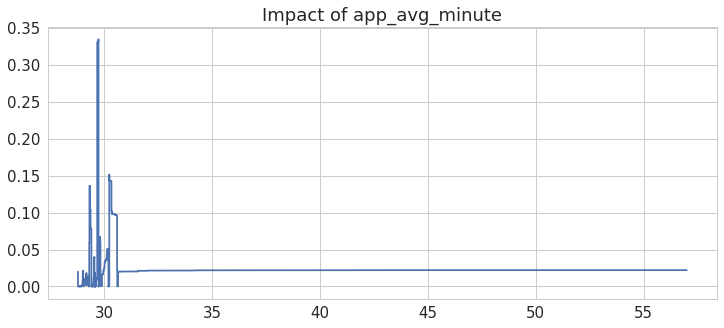

In [73]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()

# Count Features - Devices

In [74]:
from pyspark.sql.functions import count, countDistinct, col

count_features = (data
                  .groupBy('device')
                  .agg(count('device').alias('device_nb_clicks'),
                       countDistinct(col('app')).alias('device_nb_apps'),
                       countDistinct(col('ip')).alias('device_nb_ips'),
                       countDistinct(col('os')).alias('device_nb_os'),
                       countDistinct(col('channel')).alias('device_nb_channels')))

In [75]:
# Export new features
(count_features
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_counts_week_device", compression="None"))

count_features.count()

4228

### Check the impact of new features

In [76]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(count_features, ['device'], 'left_outer')
                .cache())

In [77]:
features = ['device_nb_clicks', 'device_nb_apps', 'device_nb_ips', 'device_nb_os', 'device_nb_channels']

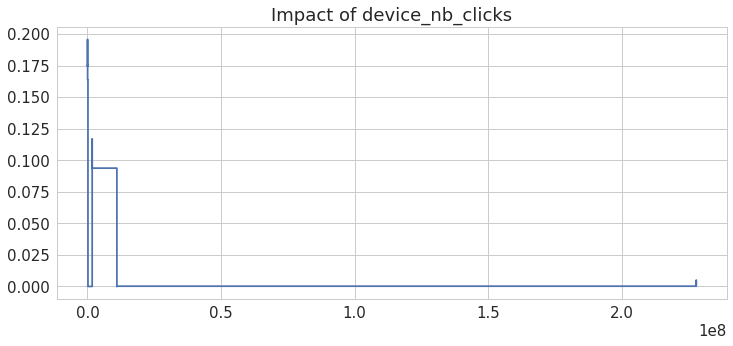

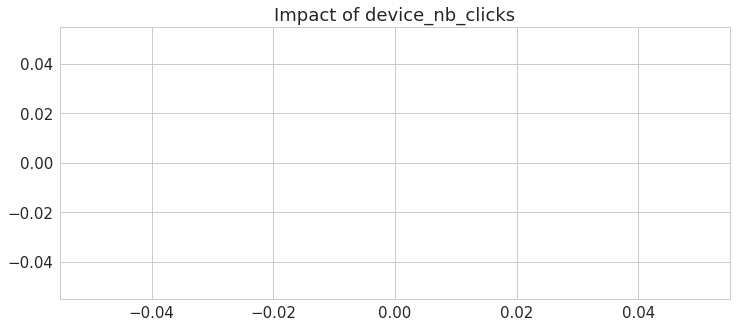

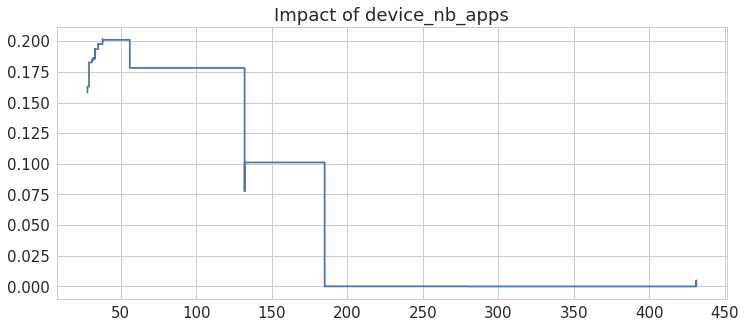

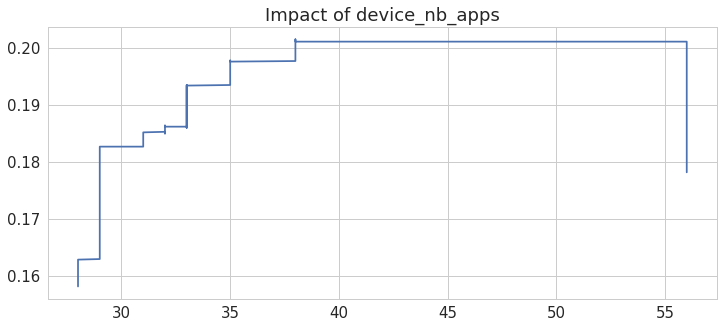

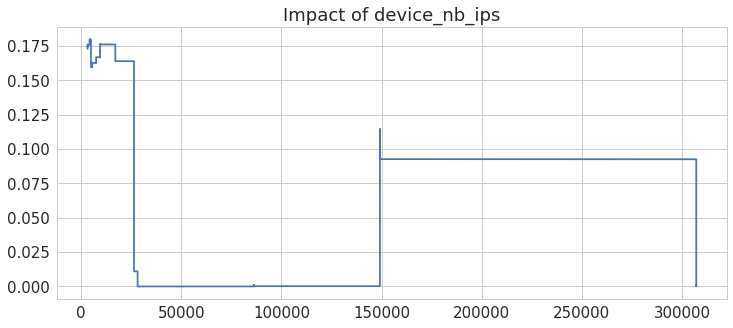

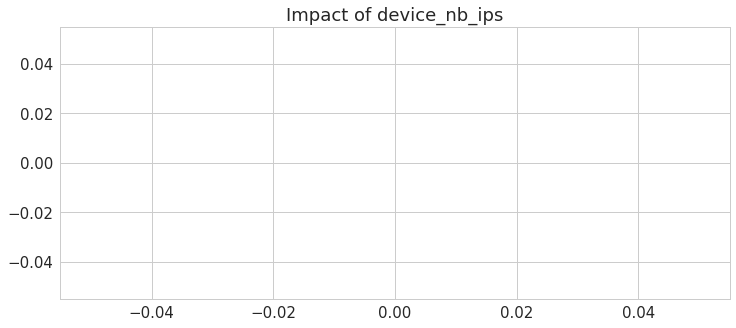

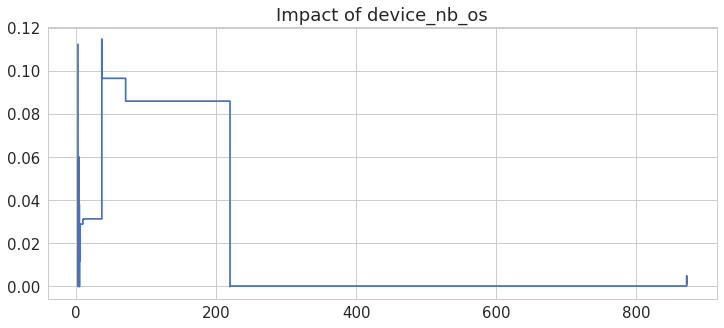

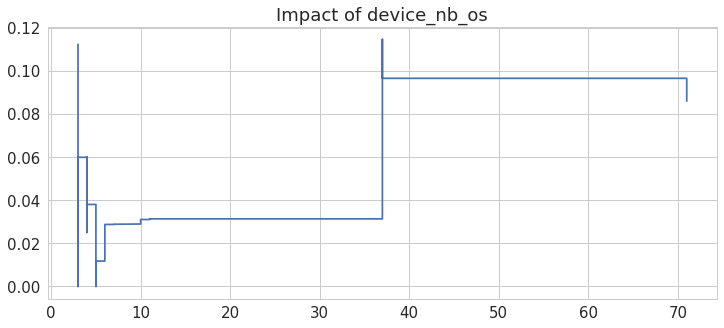

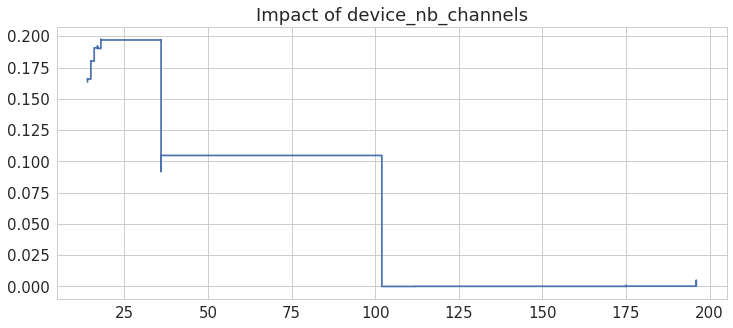

In [78]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()

# Count Features - OS

In [79]:
from pyspark.sql.functions import count, countDistinct, col

count_features = (data
                  .groupBy('os')
                  .agg(count('os').alias('os_nb_clicks'),
                       countDistinct(col('app')).alias('os_nb_apps'),
                       countDistinct(col('device')).alias('os_nb_devices'),
                       countDistinct(col('ip')).alias('os_nb_ips'),
                       countDistinct(col('channel')).alias('os_nb_channels')))

In [80]:
# Export new features
(count_features
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_counts_week_os", compression="None"))

count_features.count()

957

### Check the impact of new features

In [81]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(count_features, ['os'], 'left_outer')
                .cache())

In [84]:
features = ['os_nb_clicks', 'os_nb_ips', 'os_nb_apps', 'os_nb_devices', 'os_nb_channels']

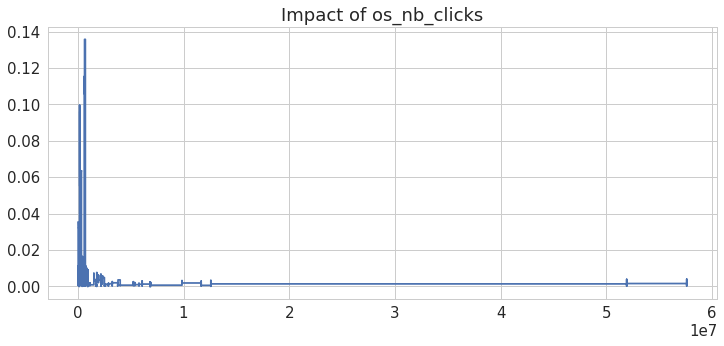

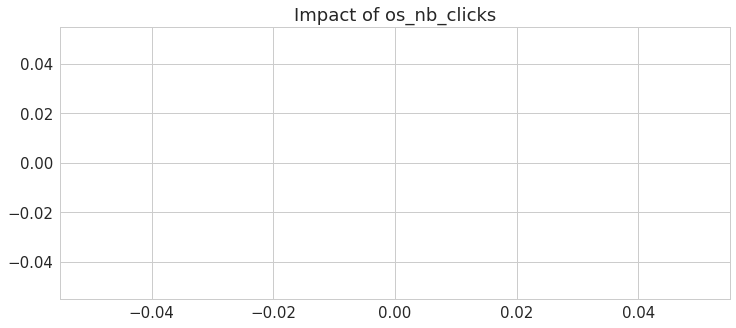

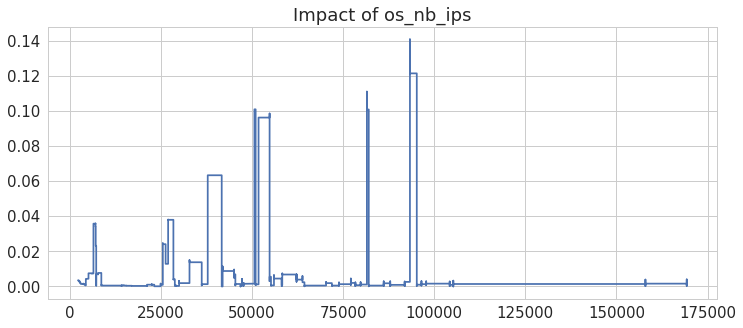

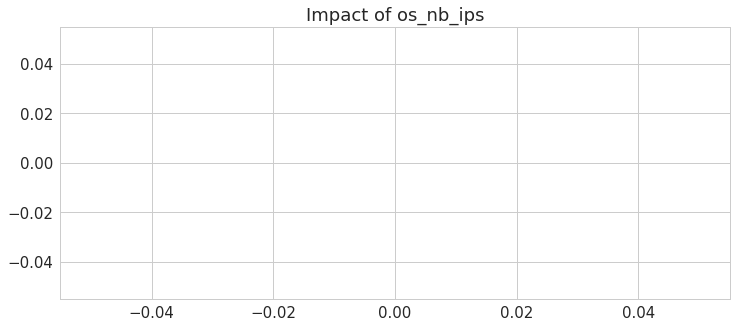

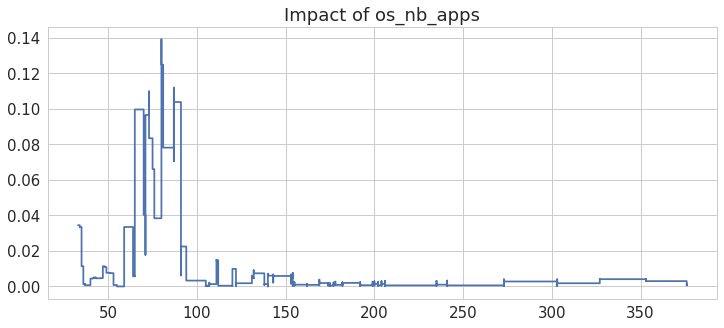

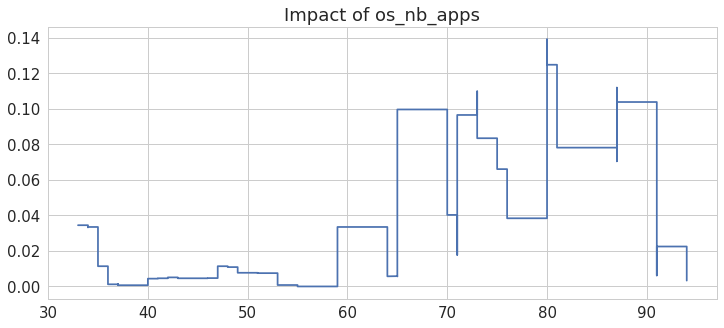

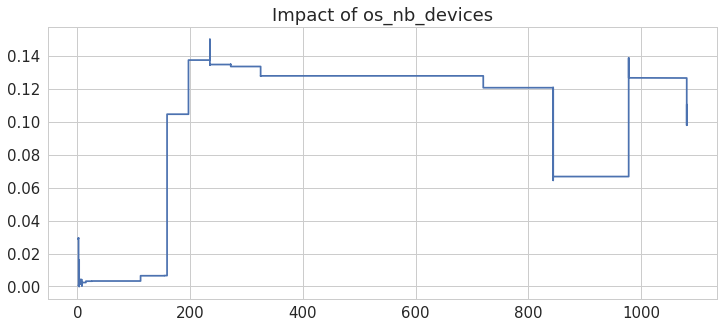

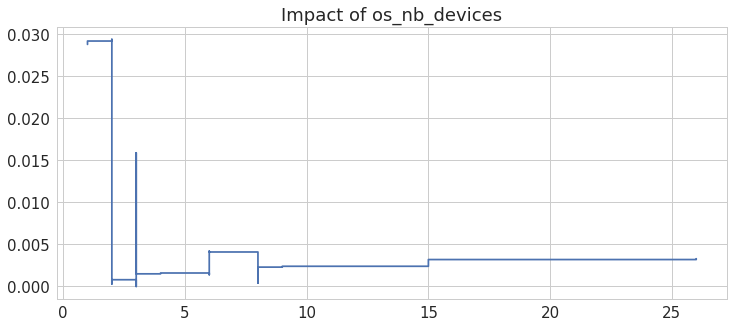

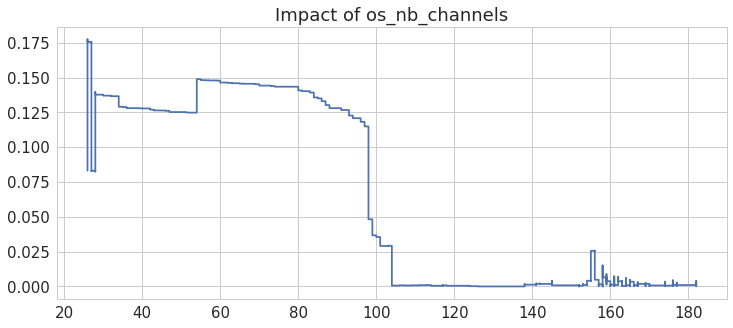

In [85]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()

# Count Features - Channels

In [86]:
from pyspark.sql.functions import count, countDistinct, col

count_features = (data
                  .groupBy('channel')
                  .agg(count('channel').alias('channel_nb_clicks'),
                       countDistinct(col('app')).alias('channel_nb_apps'),
                       countDistinct(col('device')).alias('channel_nb_devices'),
                       countDistinct(col('os')).alias('channel_nb_os'),
                       countDistinct(col('ip')).alias('channel_nb_ips')))

In [87]:
# Export new features
(count_features
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_counts_week_channel", compression="None"))

count_features.count()

204

### Check the impact of new features

In [88]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(count_features, ['channel'], 'left_outer')
                .cache())

In [89]:
features = ['channel_nb_clicks', 'channel_nb_apps', 'channel_nb_devices', 'channel_nb_os', 'channel_nb_ips']

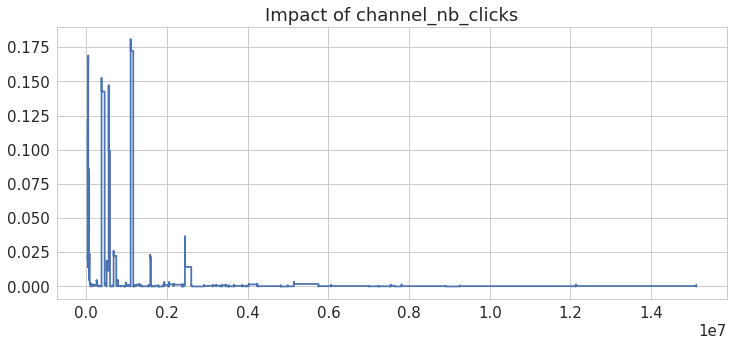

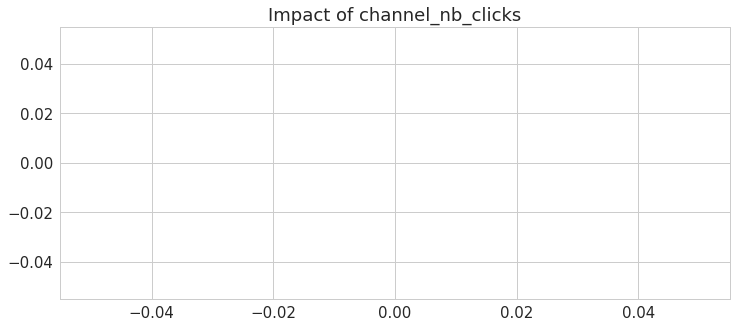

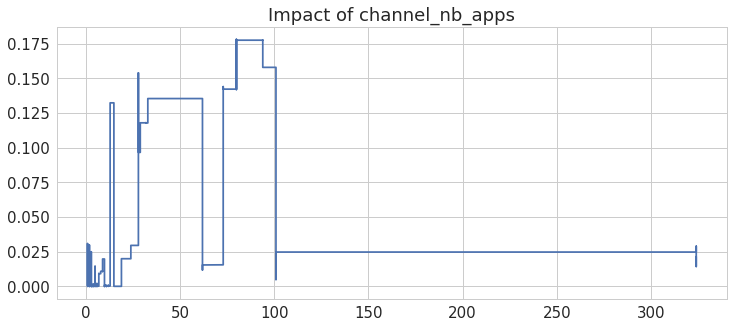

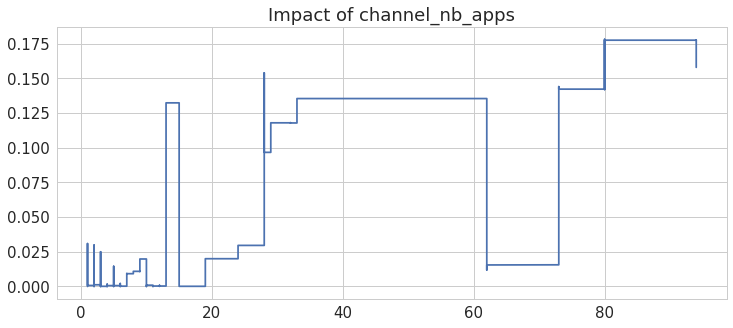

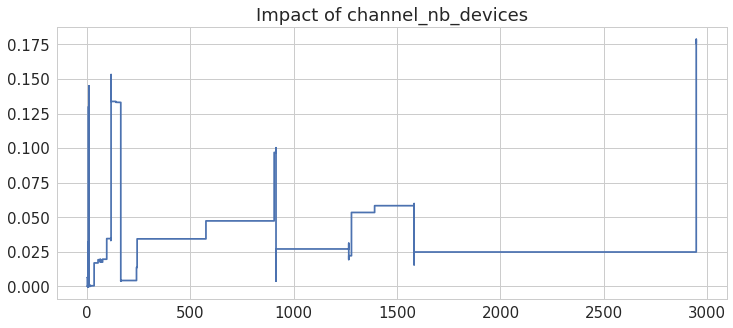

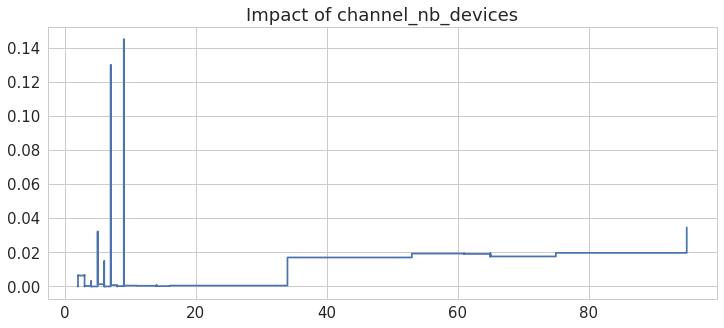

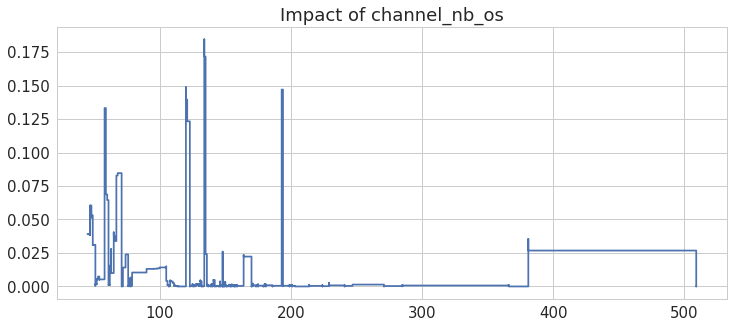

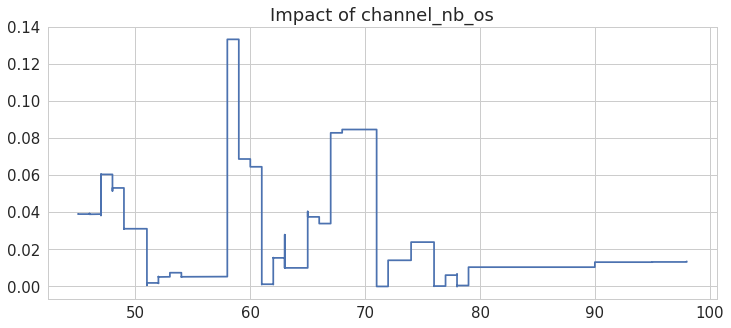

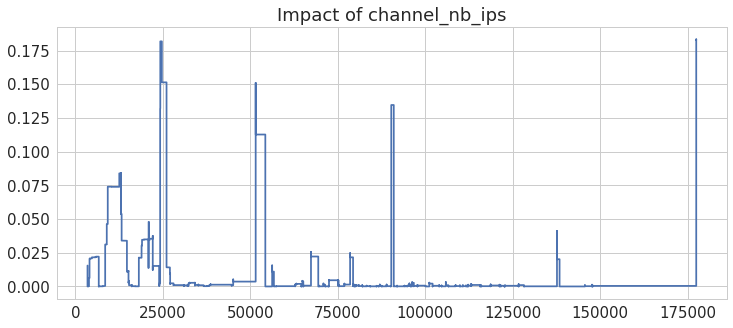

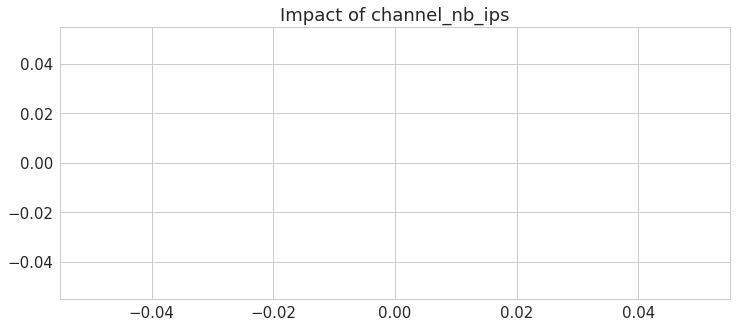

In [90]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()